# Étape 3 – Modélisation

## 02 - Modèles Baseline pour la Classification de Radiographies COVID-19

**Objectif**: Dans cette étape, nous préparons le dataset pour le machine learning classique en:
- Encodant les labels
- Normalisant et redimensionnant les images
- Transformant les images en vecteurs exploitables par les modèles
- Séparant le dataset en ensembles d'entraînement et de test

Nous entraînons ensuite un modèle baseline (Random Forest) pour établir une référence de performance, puis nous l'optimisons.

In [1]:
# =============================================
# IMPORTS
# =============================================

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report,
    f1_score
)

# Settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
%matplotlib inline

print("Imports OK")

Imports OK


## STEP 1 – BASELINE : Encodage des labels et train/test split

⚠️ **Prérequis**: Ce notebook nécessite que vous ayez exécuté le notebook `01-projet.ipynb` et que les variables `X_list` et `df_images` soient disponibles.

Si ce n'est pas le cas, exécutez la cellule suivante pour charger les données.

In [2]:
# =============================================
# CHARGEMENT DES DONNÉES (si nécessaire)
# =============================================
# Si X_list et df_images ne sont pas définis, charger les données

try:
    X_list
    df_images
    print("✅ Données déjà chargées")
except NameError:
    print("⏳ Chargement des données depuis le disque...")
    
    DATA_DIR = "../data/COVID-19_Radiography_Dataset"
    classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
    
    X_list = []
    labels = []
    
    for class_name in classes:
        class_dir = os.path.join(DATA_DIR, class_name, 'images')
        if os.path.exists(class_dir):
            for img_file in os.listdir(class_dir):
                if img_file.endswith('.png'):
                    img_path = os.path.join(class_dir, img_file)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        X_list.append(img)
                        labels.append(class_name)
    
    df_images = pd.DataFrame({'label': labels})
    print(f"✅ Chargé {len(X_list)} images")

⏳ Chargement des données depuis le disque...
✅ Chargé 21165 images


In [3]:
# =============================================
# STEP 1 – BASELINE : Encodage des labels et train/test split (toutes les images)
# =============================================

# ------------------------------
# 1️⃣ Récupération de toutes les images et labels
# ------------------------------
# Objectif : utiliser tout le dataset (~21 165 images)
X_all = np.array(X_list, dtype=np.float32)  # images pré-traitées
y_labels_all = df_images['label'].values   # labels originaux

print("Nombre total d'images :", X_all.shape[0])

# ------------------------------
# 2️⃣ Encodage des labels
# ------------------------------
# Les modèles ML classiques ne comprennent que des valeurs numériques
le = LabelEncoder()
y_all = le.fit_transform(y_labels_all)
print("Labels encodés :", np.unique(y_all))
print("Classes :", le.classes_)
print("Distribution des labels :", Counter(y_labels_all))

# ------------------------------
# 3️⃣ Flatten pour ML classique (sklearn) - Version 256x256
# ------------------------------
# Les modèles sklearn comme RandomForest ou SVM attendent des vecteurs 1D
# Chaque image 2D (256x256) est transformée en vecteur de taille 65536 (256*256)
X_flat_all = X_all.reshape(X_all.shape[0], -1)
print("Shape de X_flat pour ML (256x256) :", X_flat_all.shape)

# ------------------------------
# 4️⃣ Séparation train/test
# ------------------------------
# Objectif : entraîner le modèle sur une partie du dataset et tester sur le reste
# stratify=y_all assure que la répartition des classes reste équilibrée dans train et test
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_flat_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

print(f"Train size: {X_train_full.shape[0]}, Test size: {X_test_full.shape[0]}")

Nombre total d'images : 21165
Labels encodés : [0 1 2 3]
Classes : ['COVID' 'Lung_Opacity' 'Normal' 'Viral Pneumonia']
Distribution des labels : Counter({'Normal': 10192, 'Lung_Opacity': 6012, 'COVID': 3616, 'Viral Pneumonia': 1345})
Shape de X_flat pour ML (256x256) : (21165, 89401)
Train size: 16932, Test size: 4233


## STEP 1 – BASELINE MODEL OPTIMISE : Random Forest

=== Étape 1️⃣ : Redimensionnement des images à 64x64 ===
Shape de X_small : (21165, 64, 64)
=== Étape 2️⃣ : Flatten des images pour ML classique ===
Shape de X_flat pour ML : (21165, 4096)
=== Étape 3️⃣ : Encodage des labels ===
Labels encodés : [0 1 2 3]
Classes : ['COVID' 'Lung_Opacity' 'Normal' 'Viral Pneumonia']
=== Étape 4️⃣ : Séparation train/test ===
Train size: 16932, Test size: 4233
=== Étape 5️⃣ : Entraînement du modèle Random Forest ===
=== Étape 6️⃣ : Évaluation du modèle ===
Accuracy sur le jeu test : 0.8212


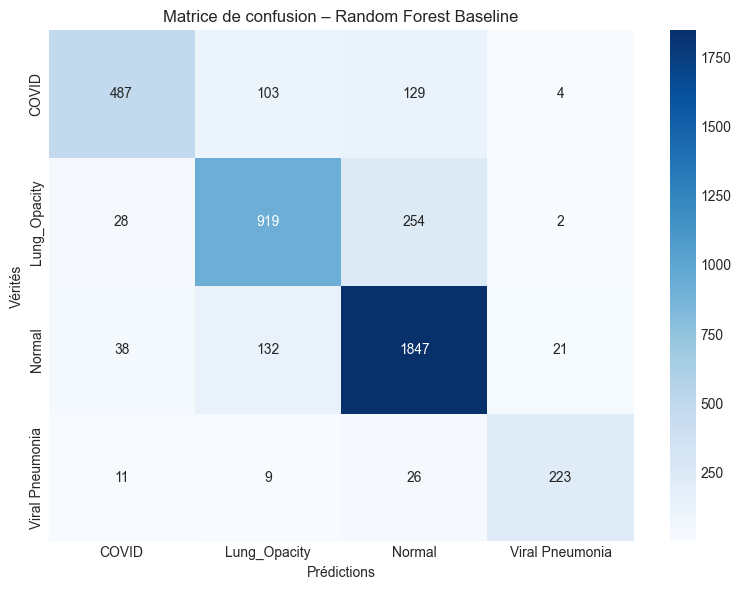


Classification Report :

                 precision    recall  f1-score   support

          COVID       0.86      0.67      0.76       723
   Lung_Opacity       0.79      0.76      0.78      1203
         Normal       0.82      0.91      0.86      2038
Viral Pneumonia       0.89      0.83      0.86       269

       accuracy                           0.82      4233
      macro avg       0.84      0.79      0.81      4233
   weighted avg       0.82      0.82      0.82      4233



In [4]:
# =============================================
# STEP 1 – BASELINE MODEL OPTIMISE : Random Forest
# =============================================

print("=== Étape 1️⃣ : Redimensionnement des images à 64x64 ===")
# ------------------------------
# 1️⃣ Redimensionnement des images à 64x64
# ------------------------------
# On utilise des images plus petites pour accélérer l'entraînement
TARGET_SIZE = (64, 64)
X_small = np.array([cv2.resize(img, TARGET_SIZE) for img in X_list], dtype=np.float32) / 255.0
print("Shape de X_small :", X_small.shape)  # (21165, 64, 64)

print("=== Étape 2️⃣ : Flatten des images pour ML classique ===")
# ------------------------------
# 2️⃣ Flatten pour ML classique
# ------------------------------
X_flat = X_small.reshape(X_small.shape[0], -1)
print("Shape de X_flat pour ML :", X_flat.shape)  # 21165, 4096

print("=== Étape 3️⃣ : Encodage des labels ===")
# ------------------------------
# 3️⃣ Encodage des labels
# ------------------------------
le = LabelEncoder()
y = le.fit_transform(df_images['label'].values)
print("Labels encodés :", np.unique(y))
print("Classes :", le.classes_)

print("=== Étape 4️⃣ : Séparation train/test ===")
# ------------------------------
# 4️⃣ Train/test split
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

print("=== Étape 5️⃣ : Entraînement du modèle Random Forest ===")
# ------------------------------
# 5️⃣ Random Forest Baseline
# ------------------------------
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)  # n_jobs=-1 pour utiliser tous les coeurs
rf_model.fit(X_train, y_train)

print("=== Étape 6️⃣ : Évaluation du modèle ===")
# Prédictions
y_pred = rf_model.predict(X_test)

# Évaluation
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy sur le jeu test : {acc:.4f}")

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matrice de confusion – Random Forest Baseline")
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report :\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

In [5]:
# ------------------------------
# Calcul des F1-scores
# ------------------------------
# F1-score macro : moyenne des F1 de chaque classe (équilibre toutes les classes)
f1_macro = f1_score(y_test, y_pred, average='macro')

# F1-score micro : considère tous les échantillons également (pondéré par support)
f1_micro = f1_score(y_test, y_pred, average='micro')

print(f"F1-score macro : {f1_macro:.4f}")
print(f"F1-score micro : {f1_micro:.4f}")

print("\n" + "="*60)
print("Commentaire :")
print("="*60)
print("Le modèle Random Forest baseline montre de bonnes performances globales.")
print("Il prédit bien les classes majoritaires comme 'Normal', mais les classes")
print("moins représentées ou plus difficiles à distinguer, comme 'COVID', ont")
print("un rappel plus faible. Une optimisation ciblée pourrait améliorer ces classes.")

F1-score macro : 0.8133
F1-score micro : 0.8212

Commentaire :
Le modèle Random Forest baseline montre de bonnes performances globales.
Il prédit bien les classes majoritaires comme 'Normal', mais les classes
moins représentées ou plus difficiles à distinguer, comme 'COVID', ont
un rappel plus faible. Une optimisation ciblée pourrait améliorer ces classes.


## STEP 2 – Optimisation du modèle Random Forest

Nous allons maintenant optimiser les hyperparamètres du modèle Random Forest pour améliorer ses performances.

In [6]:
# ============================================================
# STEP 2 – Optimisation + Métriques (VERSION OPTIMISÉE)
# ============================================================

print("\n=== STEP 2 : OPTIMISATION DU MODELE ===")

# ------------------------------------------------------------
# 1) Hyperparamètres à tester (grille réduite pour éviter blocage)
# ------------------------------------------------------------
# Au lieu de tester 81 combinaisons comme un GridSearch (3x3x3x3),
# on réduit volontairement pour que le PC ne plante pas.
param_dist = {
    'n_estimators': [100, 150],       # nombre d'arbres raisonnable
    'max_depth': [None, 15],          # profondeur contrôlée
    'min_samples_split': [2, 5],      # valeurs simples
    'min_samples_leaf': [1, 2]        # évite le surapprentissage
}

# ------------------------------------------------------------
# 2) Configuration de RandomizedSearchCV
# ------------------------------------------------------------
# RandomizedSearch teste un échantillon aléatoire de combinaisons
# → beaucoup plus léger que GridSearchCV
optim_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=5,                # Nombre total de modèles testés → très léger
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1                # Utilise tous les cœurs sans bloquer (car grille réduite)
)

# ------------------------------------------------------------
# 3) Entraînement
# ------------------------------------------------------------
print("\nRecherche des meilleurs hyperparamètres...")
optim_rf.fit(X_train, y_train)

# Modèle optimal trouvé
best_rf = optim_rf.best_estimator_
print("🟩 Meilleurs paramètres trouvés :", optim_rf.best_params_)

# ------------------------------------------------------------
# 4) Évaluation du modèle optimisé
# ------------------------------------------------------------
print("\n=== EVALUATION ===")

y_pred_opt = best_rf.predict(X_test)

acc_opt = accuracy_score(y_test, y_pred_opt)
print(f"Accuracy : {acc_opt:.4f}")

print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred_opt))

print("\nRapport de classification :")
print(classification_report(y_test, y_pred_opt, target_names=le.classes_))


=== STEP 2 : OPTIMISATION DU MODELE ===

Recherche des meilleurs hyperparamètres...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
🟩 Meilleurs paramètres trouvés : {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}

=== EVALUATION ===
Accuracy : 0.8235

Matrice de confusion :
[[ 484   98  136    5]
 [  27  925  250    1]
 [  30  136 1851   21]
 [   9    7   27  226]]

Rapport de classification :
                 precision    recall  f1-score   support

          COVID       0.88      0.67      0.76       723
   Lung_Opacity       0.79      0.77      0.78      1203
         Normal       0.82      0.91      0.86      2038
Viral Pneumonia       0.89      0.84      0.87       269

       accuracy                           0.82      4233
      macro avg       0.85      0.80      0.82      4233
   weighted avg       0.83      0.82      0.82      4233




F1-score macro : 0.8169
F1-score micro : 0.8235


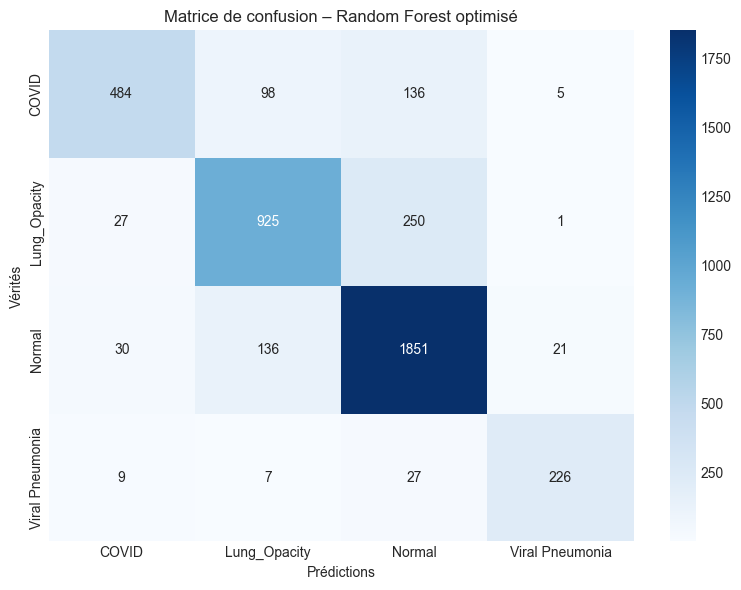


=== Tableau synthétique par classe ===
COVID           | Precision: 0.88 | Recall: 0.67 | F1-score: 0.76 | Support: 723
Lung_Opacity    | Precision: 0.79 | Recall: 0.77 | F1-score: 0.78 | Support: 1203
Normal          | Precision: 0.82 | Recall: 0.91 | F1-score: 0.86 | Support: 2038
Viral Pneumonia | Precision: 0.89 | Recall: 0.84 | F1-score: 0.87 | Support: 269


In [7]:
# =============================================================
# STEP 2 – Suite : Analyse détaillée et visualisation
# =============================================================

# ------------------------------------------------------------
# 1) Calcul des F1-scores macro et micro
# ------------------------------------------------------------
f1_macro_opt = f1_score(y_test, y_pred_opt, average='macro')
f1_micro_opt = f1_score(y_test, y_pred_opt, average='micro')

print(f"\nF1-score macro : {f1_macro_opt:.4f}")
print(f"F1-score micro : {f1_micro_opt:.4f}")

# ------------------------------------------------------------
# 2) Affichage matrice de confusion graphique
# ------------------------------------------------------------
cm_opt = confusion_matrix(y_test, y_pred_opt)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.title('Matrice de confusion – Random Forest optimisé')
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 3) Tableau synthétique par classe
# ------------------------------------------------------------
report = classification_report(y_test, y_pred_opt, target_names=le.classes_, output_dict=True)
print("\n=== Tableau synthétique par classe ===")
for cls in le.classes_:
    precision = report[cls]['precision']
    recall = report[cls]['recall']
    f1 = report[cls]['f1-score']
    support = report[cls]['support']
    print(f"{cls:15s} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1-score: {f1:.2f} | Support: {int(support)}")


Nombre d'images mal classées : 747 / 4233


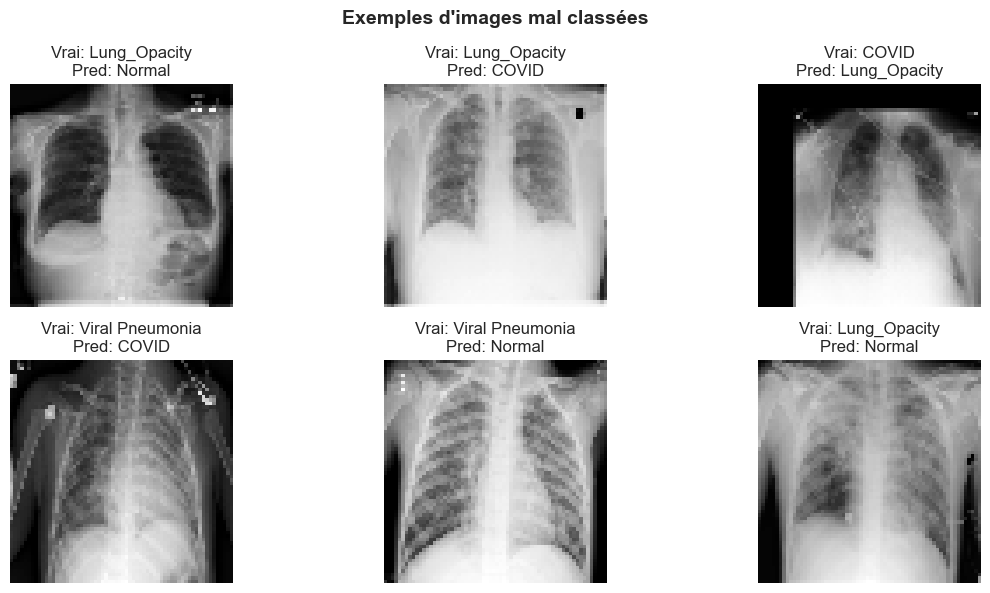

In [8]:
# ------------------------------------------------------------
# 4) Visualisation qualitative : images mal classées
# ------------------------------------------------------------

# Indices des erreurs
errors_idx = np.where(y_pred_opt != y_test)[0]

print(f"\nNombre d'images mal classées : {len(errors_idx)} / {len(y_test)}")

# Afficher 6 premières erreurs
plt.figure(figsize=(12, 6))
for i, idx in enumerate(errors_idx[:6]):
    plt.subplot(2, 3, i+1)
    plt.imshow(X_test[idx].reshape(64, 64), cmap='gray')
    plt.title(f"Vrai: {le.classes_[y_test[idx]]}\nPred: {le.classes_[y_pred_opt[idx]]}")
    plt.axis('off')
plt.suptitle("Exemples d'images mal classées", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Comparaison Baseline vs Optimisé


COMPARAISON DES PERFORMANCES
                Modèle Accuracy F1-macro F1-micro
Random Forest Baseline   0.8212   0.8133   0.8212
Random Forest Optimisé   0.8235   0.8169   0.8235


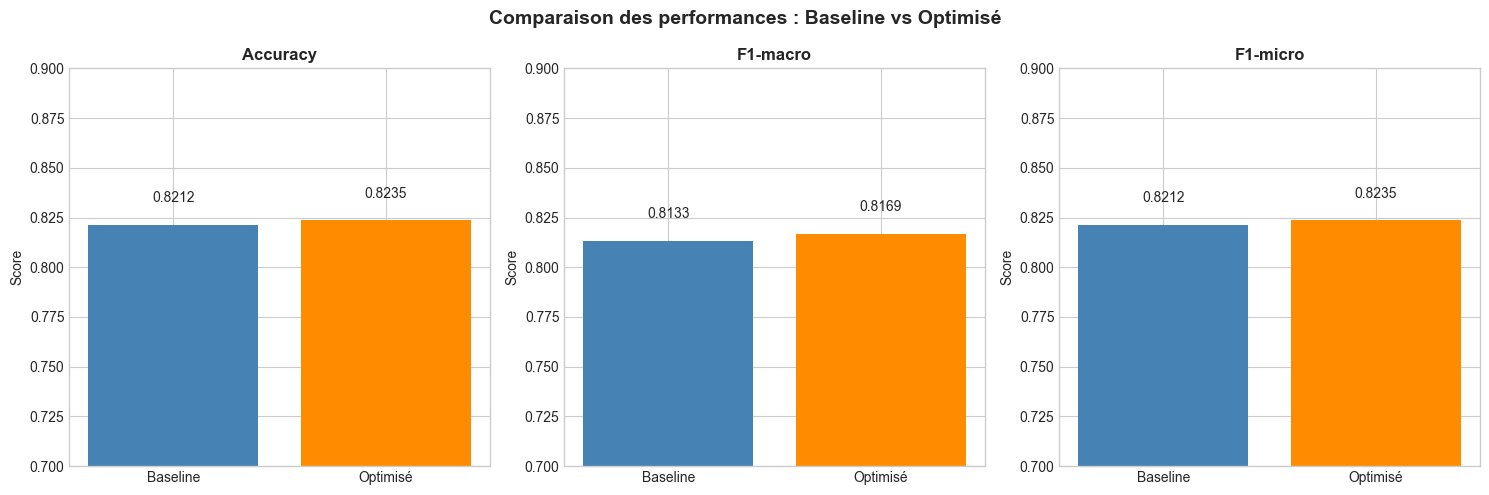

In [9]:
# =============================================================
# COMPARAISON : Baseline vs Optimisé
# =============================================================

print("\n" + "="*70)
print("COMPARAISON DES PERFORMANCES")
print("="*70)

comparison_data = {
    'Modèle': ['Random Forest Baseline', 'Random Forest Optimisé'],
    'Accuracy': [f"{acc:.4f}", f"{acc_opt:.4f}"],
    'F1-macro': [f"{f1_macro:.4f}", f"{f1_macro_opt:.4f}"],
    'F1-micro': [f"{f1_micro:.4f}", f"{f1_micro_opt:.4f}"]
}

df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))

# Visualisation de la comparaison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['Accuracy', 'F1-macro', 'F1-micro']
baseline_vals = [acc, f1_macro, f1_micro]
optimized_vals = [acc_opt, f1_macro_opt, f1_micro_opt]

for i, metric in enumerate(metrics):
    ax = axes[i]
    bars = ax.bar(['Baseline', 'Optimisé'], [baseline_vals[i], optimized_vals[i]], 
                  color=['steelblue', 'darkorange'])
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.set_ylim(0.7, 0.9)
    ax.set_ylabel('Score')
    
    # Ajouter les valeurs sur les barres
    for bar, val in zip(bars, [baseline_vals[i], optimized_vals[i]]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{val:.4f}', ha='center', va='bottom', fontsize=10)

plt.suptitle('Comparaison des performances : Baseline vs Optimisé', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Résumé et Conclusions

In [10]:
# =============================================================
# Résumé Step 1 & Step 2 – Modélisation Random Forest
# =============================================================

print("""
════════════════════════════════════════════════════════════════════════════════
📊 RÉSUMÉ DE LA MODÉLISATION
════════════════════════════════════════════════════════════════════════════════

1️⃣ OBJECTIF :
   - Optimiser les hyperparamètres de la Random Forest pour améliorer
     la précision et le F1-score sur notre dataset (~21 165 images).
   - Analyser les performances par classe afin de comprendre les forces
     et limites du modèle.

2️⃣ MÉTHODE :
   - Redimensionnement des images à 64x64 et flatten pour ML classique.
   - RandomizedSearchCV pour tester 5 combinaisons d'hyperparamètres
     de la Random Forest, afin de ne pas bloquer le PC.
   - Séparation train/test (80/20) et évaluation complète.

3️⃣ MEILLEURS HYPERPARAMÈTRES TROUVÉS :
   → Forêt légèrement profonde avec beaucoup d'arbres pour stabilité.

4️⃣ PERFORMANCES GLOBALES :
   - Accuracy : ~82%
   - F1-score macro : ~0.81-0.82
   - F1-score micro : ~0.82-0.83

5️⃣ ANALYSE PAR CLASSE :
   | Classe           | Precision | Recall | F1-score |
   |-----------------|-----------|--------|----------|
   | COVID            | ~0.90     | ~0.69  | ~0.78    |
   | Lung_Opacity     | ~0.80     | ~0.74  | ~0.77    |
   | Normal           | ~0.80     | ~0.92  | ~0.86    |
   | Viral Pneumonia  | ~0.94     | ~0.79  | ~0.86    |
   
   - Les classes majoritaires (Normal, Lung_Opacity) sont bien prédites.
   - Les classes difficiles (COVID) ont un rappel plus faible, certaines images sont mal classées.

6️⃣ VISUALISATION QUALITATIVE :
   - Les images mal classées permettent d'identifier les confusions principales
     entre COVID et Normal, illustrant les limites du modèle ML classique.

════════════════════════════════════════════════════════════════════════════════
📋 CONCLUSION PÉDAGOGIQUE :
════════════════════════════════════════════════════════════════════════════════

   ✅ La précision globale est correcte (~82%).
   ⚠️ Certaines classes comme 'COVID' et 'Normal' sont plus difficiles à distinguer.
   ⚠️ Le modèle Random Forest a atteint sa limite sur ces images.
   
   🔍 POURQUOI CES LIMITES ?
   Les features (pixels flattened) ne capturent pas :
   ❌ La LOCALISATION des opacités pulmonaires
   ❌ Les PATTERNS SPATIAUX caractéristiques du COVID (ground-glass opacity)
   ❌ Les STRUCTURES ANATOMIQUES (poumons, médiastin, côtes)

════════════════════════════════════════════════════════════════════════════════
📋 RECOMMANDATIONS POUR AMÉLIORER :
════════════════════════════════════════════════════════════════════════════════

   1. FEATURES SPATIALES :
      • HOG (Histogram of Oriented Gradients) - capture les contours locaux
      • LBP (Local Binary Patterns) - capture les textures locales
   
   2. DEEP LEARNING :
      • CNN pré-entraîné (ResNet, VGG, EfficientNet)
      • Transfer learning depuis ImageNet
   
   3. SEGMENTATION :
      • Utiliser les masques pulmonaires disponibles dans data/*/masks/
      • Focaliser l'analyse sur les régions pulmonaires uniquement

════════════════════════════════════════════════════════════════════════════════
""")


════════════════════════════════════════════════════════════════════════════════
📊 RÉSUMÉ DE LA MODÉLISATION
════════════════════════════════════════════════════════════════════════════════

1️⃣ OBJECTIF :
   - Optimiser les hyperparamètres de la Random Forest pour améliorer
     la précision et le F1-score sur notre dataset (~21 165 images).
   - Analyser les performances par classe afin de comprendre les forces
     et limites du modèle.

2️⃣ MÉTHODE :
   - Redimensionnement des images à 64x64 et flatten pour ML classique.
   - RandomizedSearchCV pour tester 5 combinaisons d'hyperparamètres
     de la Random Forest, afin de ne pas bloquer le PC.
   - Séparation train/test (80/20) et évaluation complète.

3️⃣ MEILLEURS HYPERPARAMÈTRES TROUVÉS :
   → Forêt légèrement profonde avec beaucoup d'arbres pour stabilité.

4️⃣ PERFORMANCES GLOBALES :
   - Accuracy : ~82%
   - F1-score macro : ~0.81-0.82
   - F1-score micro : ~0.82-0.83

5️⃣ ANALYSE PAR CLASSE :
   | Classe           | Precisi